<a href="https://colab.research.google.com/github/viniciusrpb/cic0087_natural_language_processing/blob/main/ner_aula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial de reconhecimento de entidades nomeadas

Olá! Meu nome é Matheus, e esse notebook é um tutorial de reconhecimento de entidades nomeadas. Vamos começar!

Repositório com os dados que utilizaremos:

In [ ]:
!git clone -s https://github.com/mstauffer/tcdf_text_classification.git

Cloning into 'tcdf_text_classification'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 40 (delta 14), reused 32 (delta 8), pack-reused 0
Unpacking objects: 100% (40/40), done.


Reconhecimento de entidades nomeadas (NER) é uma tarefa de processamento de linguagem natural super importante. Como o próprio nome já diz, o objetivo é identificar sequências de tokens, denominadas entidades, e classificá-las em categorias pré-definidas - e daí vem o entidades 'nomeadas'.

Observe o exemplo abaixo:

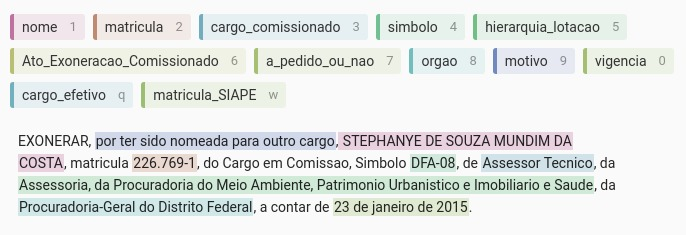

In [ ]:
from IPython.display import Image
Image('/content/tcdf_text_classification/exemplo_tag_ner.jpeg')

Em tarefas de classificação de textos, o seu input serão vários exemplos de texto com rótulos associados.

| Input                                                                                                                        | Label                          |
|------------------------------------------------------------------------------------------------------------------------------|--------------------------------|
| Exonerar, a pedido, Fulano de Tal do cargo em comissão de Gerente, da Gerência Geral, da Secretaria de Ciência e Tecnologia. | Ato de exoneração comissionado |
| Nomear Ciclano Silva para o cargo em comissão de Gerente, da Gerência Geral, da Secretaria de Ciência e Tecnologia.          | Ato de nomeação comissionado   |

Já em tarefas de NER, o input também vem com exemplos de texto, mas cada rótulo está associado a uma sequência de tokens dentro do exemplo analisado.

| Input                                                                                                                        | Label                          |
|------------------------------------------------------------------------------------------------------------------------------|--------------------------------|
| a pedido                                                                                                                     | a pedido ou não                |
| Fulano de Tal                                                                                                                | Nome                           |
| Gerente                                                                                                                      | Cargo Comissionado             |
| Gerência Geral                                                                                                               | Hierarquia de lotação          |
| Secretaria de Ciência e Tecnologia                                                                                           | Orgão
| Exonerar, a pedido, Fulano de tal do cargo em comissão de Gerente, da Gerência Geral, da Secretaria de Ciência e Tecnologia. | Ato de exoneração comissionado |                          |
| Ciclano Silva                                                                                                                | Nome                           |
| Gerente                                                                                                                      | Cargo Comissionado             |
| Gerência Geral                                                                                                               | Hierarquia de lotação          |
| Secretaria de Ciência e Tecnologia                                                                                           | Orgão                          |
| Nomear Ciclano Silva para o cargo em comissão de Gerente, da Gerência Geral, da Secretaria de Ciência e Tecnologia.          | Ato de nomeação comissionado   |


Dessa forma, o modus operandi mais comum de NER pede que se converta o input em um formato que identique a menção de alguma entidade nomeada e seus tokens de começo e fim.

Disso vem o formato IOB. Esse formato olha para cada token de determinado exemplo de texto e o caracteriza como sendo o token de início de determinada entidade (B-entidade) ou um token contido em determinada entidade (I-entidade) - B vem de *begin* e I de *inside*. Vejamos um exemplo:

| Token      | Label                |
|------------|----------------------|
| Exonerar   | O                    |
| ,          | O                    |
| a          | B-a_pedido_ou_nao    |
| pedido     | I-a_pedido_ou_nao    |
| ,          | O                    |
| Fulano     | B-nome               |
| de         | I-nome               |
| Tal        | I-nome               |
| do         | O                    |
| cargo      | O                    |
| em         | O                    |
| comissão   | O                    |
| de         | O                    |
| Gerente    | B-cargo_comissionado |
| ,          | O                    |
| da         | O                    |
| Gerência   | B-hierarquia_lotacao |
| Geral      | I-hierarquia_lotacao |
| ,          | O                    |
| da         | O                    |
| Secretaria | B-orgao              |
| de         | I-orgao              |
| Ciência    | I-orgao              |
| e          | I-orgao              |
| Tecnologia | I-orgao              |
| .          | O                    |



Com as entradas no formato correto, podemos prosseguir com a representação dos dados textuais e aplicação de algoritmos de aprendizado de máquina.

Para referências complementares, eu sugiro os três recursos abaixo:
- Introdução ao Reconhecimento de Entidade Nomeadas, da UFMG: https://youtu.be/bAHJaqbhhgI
- Introduction to Information Retrieval, de Stanford: https://youtu.be/Tj3Dkiw-iZg
- A Survey on Deep Learning for Named Entity Recognition, https://arxiv.org/pdf/1812.09449.pdf.

## Extraindo IOBs do conjunto de dados

In [ ]:
import pandas as pd

df = pd.read_csv('/content/tcdf_text_classification/dodf_atos.csv')
df

,id_dodf,tipo_rel,id_rel,anotador_rel,tipo_ent,id_ent,anotador_ent,offset,length,texto
0,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,nome,3537,carlos_gabriel,197948,23,YURI MACHADO DE MENEZES
1,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,matricula,3538,carlos_gabriel,197983,8,61.836-5
2,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,vigencia,3539,carlos_gabriel,198021,22,12 de setembro de 2008
3,80_194.30.9.8,Ato_Reversao,R1,carlos_gabriel,Ato_Reversao,3540,carlos_gabriel,197866,178,REVERTER o REGIME DE TEMPO INTEGRAL E DEDICACA...
4,87_118.20.6.8,Ato_Nomeacao_Comissionado,R1,lygia_paloma,nome,1583,lygia_paloma,212316,28,JOAO PAULO PATROCINA MARQUES
...,...,...,...,...,...,...,...,...,...,...
20750,13_212.10.10.2013,Ato_Substituicao,R40,khalil_carsten,matricula_substituido,8685,vinicius_borges,644324,9,174.833-5
20751,13_212.10.10.2013,Ato_Substituicao,R40,khalil_carsten,data_inicial,8686,vinicius_borges,644348,2,09
20752,13_212.10.10.2013,Ato_Substituicao,R40,khalil_carsten,data_final,8687,vinicius_borges,644353,10,11/10/2013
20753,13_212.10.10.2013,Ato_Substituicao,R40,khalil_carsten,motivo,8688,vinicius_borges,644380,32,ferias regulamentares da titular


In [ ]:
df['id_ato'] = df['id_dodf'] + '-' + df['id_rel']

In [ ]:
from tcdf_text_classification.iob_transformer import iob_transformer

In [ ]:
iob = iob_transformer('id_ato', 'texto',
                      'tipo_ent', keep_punctuation=True, return_df=False)

In [ ]:
iob_d = iob_transformer('id_ato', 'texto',
                      'tipo_ent', keep_punctuation=True, return_df=True)

In [ ]:
# a sessão do colab não possui instalado por padrão
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
atos, labels = iob.transform(df)

In [ ]:
df_iob = iob_d.transform(df)
df_iob

,Sentence_idx,Word,Tag
0,-1,UNK,O
1,0,REVERTER,O
2,0,o,O
3,0,REGIME,O
4,0,DE,O
...,...,...,...
147950,2255,ferias,B-motivo
147951,2255,regulamentares,I-motivo
147952,2255,da,I-motivo
147953,2255,titular,I-motivo


### Import de módulos

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


### Listas para palavras e tags únicas

In [ ]:
words = set()
for ato in atos:
    for termo in ato:
        words.add(termo)
words = list(words)
words.append("ENDPAD")
words.append("UNK")
num_words = len(words)

In [ ]:
num_words

7732

In [ ]:
tags = set()

for label in labels:
    for tag in label:
        tags.add(tag)
tags = list(tags)
num_tags = len(tags)

In [ ]:
num_tags

115

In [ ]:
tags

['B-vigencia',
 'B-informacao_errada',
 'B-matricula_SIAPE',
 'I-cargo',
 'I-orgao_cedente',
 'B-lotacao',
 'B-cargo_orgao_cessionario',
 'B-data_documento',
 'I-candidato',
 'B-orgao_cedente',
 'I-orgao_cessionario',
 'I-tipo_documento',
 'I-data_dodf',
 'I-cargo_objeto_susbtituicao',
 'B-data_dodf_edital_normativo',
 'I-carreira',
 'I-nome_substituto',
 'I-tipo_ato',
 'I-lotacao',
 'B-tipo_documento',
 'I-matricula_substituto',
 'I-data_edital_normativo',
 'B-hierarquia_lotacao',
 'B-numero_dodf_resultado_final',
 'I-data_documento',
 'B-data_inicial',
 'B-matricula_substituido',
 'B-cargo_objeto_susbtituicao',
 'B-edital_resultado_final',
 'I-edital_normativo',
 'B-especialiade',
 'B-orgao_cessionario',
 'B-cargo',
 'I-motivo',
 'B-classe',
 'I-informacao_corrigida',
 'I-quadro',
 'I-data_inicial',
 'I-orgao',
 'B-data_dodf',
 'I-especialiade',
 'I-hierarquia_lotacao',
 'I-fundamento_legal',
 'I-nome',
 'I-tipo_edicao',
 'I-matricula',
 'B-hierarqui_lotacao',
 'I-especialidade',
 'B

### Mapeamento de palavras e tags em valores inteiros

Eis os dicts!

In [ ]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
word2idx['UNK']

7732

### Padding das sentenças

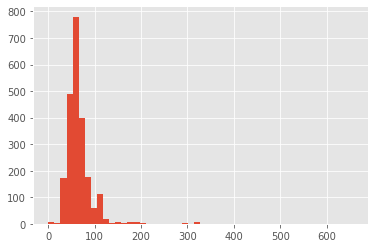

In [ ]:
plt.hist([len(ato) for ato in atos], bins=50)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 128

X = [[word2idx[w] for w in ato] for ato in atos]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx['ENDPAD'])

y = [[tag2idx[w] for w in label] for label in labels]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Você pode variar o tamanho do conjunto de testes e de validação, caso queira.

In [ ]:
from sklearn.model_selection import train_test_split
# 80% treino, 20% teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# 10% teste, 10% validação
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

### Rede Neural: Bi-LSTM

Você também pode explorar outras possibilidades para montar a rede neural. Aqui, eu usei só uma BiLSTM. Você pode adicionar uma camada CRF no final dessa abordagem e obter o que era o estado da arte até pouco tempo atrás. Também é possível fazer NER usando só CRF. São muitas possibilidades, aí vale testar e ver o que funciona melhor.

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words+1, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 50)           386650    
                                                                 
 spatial_dropout1d (SpatialD  (None, 128, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128, 200)         120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 128, 115)         23115     
 ibuted)                                                         
                                                             

Outro ponto que pode ser explorado é otimizador. É um fator de impacto no treinamento da rede. Outras opções estão aqui, https://keras.io/api/optimizers/.

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Treinamento do modelo

In [ ]:
!pip install livelossplot

     |████████████████████████████████| 793 kB 30.0 MB/s 
     |████████████████████████████████| 381 kB 46.6 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

Vamos treinar por 15 épocas em CPU. Você pode mudar esse número de acordo com o gráfico de acurácia e loss: se você treinou e viu que os gráficos não estabilizaram, talvez possa ser interessante aumentar o número de épocas. Usando o EarlyStopping a rede para de treinar se o modelo não melhorar em mais de n épocas consecutivas, onde n é o parâmetro de patience.

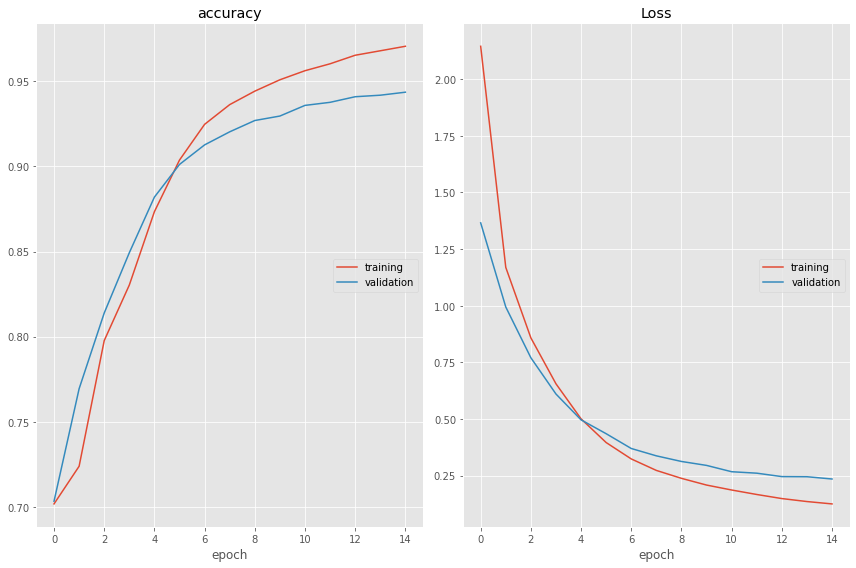

accuracy
	training         	 (min:    0.702, max:    0.971, cur:    0.971)
	validation       	 (min:    0.703, max:    0.944, cur:    0.944)
Loss
	training         	 (min:    0.125, max:    2.145, cur:    0.125)
	validation       	 (min:    0.235, max:    1.366, cur:    0.235)

Epoch 15: val_loss improved from 0.24528 to 0.23524, saving model to model.h5
57/57 [==============================] - 27s 470ms/step - loss: 0.1253 - accuracy: 0.9705 - val_loss: 0.2352 - val_accuracy: 0.9435
CPU times: user 12min 11s, sys: 32.7 s, total: 12min 44s
Wall time: 7min 27s


In [ ]:
%%time

chkpt = ModelCheckpoint("model.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

### Avaliação do modelo e funções de inferência

Fomos bem na acurácia, mas esse valor é meio ilusório por levar em conta também a classe O, que é muito predominante.

In [ ]:
model.evaluate(x_val, y_val)

8/8 [==============================] - 1s 67ms/step - loss: 0.1887 - accuracy: 0.9543


[0.18867789208889008, 0.9543349146842957]

Dessa forma, vamos testar o F1-Score usando a lib seqeval.

In [ ]:
y_pred_lstm = model.predict(x_val, batch_size=32, verbose=2)
# explicação shape: (instâncias, palavras em cada instância(max_len), prob de cada label)
y_pred_lstm.shape

8/8 - 1s - 962ms/epoch - 120ms/step


(226, 128, 115)

In [ ]:
y_val.shape

(226, 128)

In [ ]:
index_array = np.argmax(y_pred_lstm, axis=-1)
index_array.shape

(226, 128)

#### F1-Score com Seqeval

In [ ]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=5cff2f6e098a6e60f57ec97a6d6059a6f3cec0bb73546f23d16a55e9133e13cd
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, classification_report

In [ ]:
# para usar no seqeval
idx2tag = {v: k for k, v in tag2idx.items()}
idx2tag

{0: 'B-vigencia',
 1: 'B-informacao_errada',
 2: 'B-matricula_SIAPE',
 3: 'I-cargo',
 4: 'I-orgao_cedente',
 5: 'B-lotacao',
 6: 'B-cargo_orgao_cessionario',
 7: 'B-data_documento',
 8: 'I-candidato',
 9: 'B-orgao_cedente',
 10: 'I-orgao_cessionario',
 11: 'I-tipo_documento',
 12: 'I-data_dodf',
 13: 'I-cargo_objeto_susbtituicao',
 14: 'B-data_dodf_edital_normativo',
 15: 'I-carreira',
 16: 'I-nome_substituto',
 17: 'I-tipo_ato',
 18: 'I-lotacao',
 19: 'B-tipo_documento',
 20: 'I-matricula_substituto',
 21: 'I-data_edital_normativo',
 22: 'B-hierarquia_lotacao',
 23: 'B-numero_dodf_resultado_final',
 24: 'I-data_documento',
 25: 'B-data_inicial',
 26: 'B-matricula_substituido',
 27: 'B-cargo_objeto_susbtituicao',
 28: 'B-edital_resultado_final',
 29: 'I-edital_normativo',
 30: 'B-especialiade',
 31: 'B-orgao_cessionario',
 32: 'B-cargo',
 33: 'I-motivo',
 34: 'B-classe',
 35: 'I-informacao_corrigida',
 36: 'I-quadro',
 37: 'I-data_inicial',
 38: 'I-orgao',
 39: 'B-data_dodf',
 40: 'I-e

In [ ]:
# seqeval pede listas de listas de strings como entrada.
# esse pós-processamento mapeia os labels inteiros com suas
# respectivas strings. É importante montar listas para atos
# e fazer append dessas listas com a lista externa depois.
# SÓ FUNCIONA DESSE JEITO!
def numpy_to_seqeval(y_true, y_pred):
  '''
    Parameters:
    y_true: labels verdadeiros (num_atos, max_len)
    y_pred: saída do model.predict com argmax axis=-1 (num_atos, max_len)

    Returns:
    ground_truth: lista de listas com strings de cada tag para
    os labels verdadeiros
    tags_preditas: lista de listas com strings de cada tag para
    os labels preditos
  '''
  tags_preditas = []
  ground_truth = []
  for ato in y_pred:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(idx2tag[palavra])
    tags_preditas.append(tags_ato)

  for ato in y_true:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(idx2tag[palavra])
    ground_truth.append(tags_ato)
  
  return ground_truth, tags_preditas

In [ ]:
gt, tags_pred = numpy_to_seqeval(y_val, index_array)

In [ ]:
f1_score(gt, tags_pred)

0.7345594290419983

In [ ]:
print(classification_report(gt, tags_pred))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

             a_pedido_ou_nao       0.88      1.00      0.94        15
                   candidato       0.00      0.00      0.00        16
               candidato_PNE       0.00      0.00      0.00         1
                       cargo       0.00      0.00      0.00         1
          cargo_comissionado       0.84      0.90      0.87       154
               cargo_efetivo       0.38      0.57      0.46        40
   cargo_objeto_susbtituicao       0.33      0.31      0.32        13
     cargo_orgao_cessionario       0.00      0.00      0.00         2
            cargo_substituto       0.20      0.09      0.13        11
                    carreira       0.33      0.36      0.35        11
                      classe       1.00      0.67      0.80        15
              data_documento       0.82      0.78      0.80        68
                   data_dodf       0.88      0.82      0.85        71
  data_dodf_edital_

#### Função de inferência

In [ ]:
# O colab reclama disso
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
tag2idx

Precisamos do texto de entrada, do modelo, do max_len do modelo, e dos dicts word2idx e idx2tag. Basicamente, a função tem 3 passos:
1. Pré-processamento da entrada de acordo com o padrão requerido pelo modelo;
2. Predição de fato usando o modelo na entrada processada;
3. Mapeamento dos tokens encontrados e retorno da string final.

In [ ]:
from nltk import word_tokenize

In [ ]:
def passito_passito(texto, max_len):
    # se keep_punctuation == True
    texto_tokenizado = word_tokenize(texto)
    # caso contrário
    # tokenizador = Regexptokenizer('\w+')
    # texto_tokenizado = tokenizador.tokenize(texto)
    trechos = []
    if len(texto_tokenizado) > max_len:
        num_listas = len(texto_tokenizado) // max_len
        idx_tokens_restantes = num_listas*max_len
        inicio = 0
        for num in range(num_listas):
            fim = (num+1)*max_len
            lista = texto_tokenizado[inicio:fim]
            inicio = (num+1)*max_len
            trechos.append(lista)
            if num == num_listas-1:
                lista = texto_tokenizado[idx_tokens_restantes:]
                trechos.append(lista)
    else:
        trechos.append(texto_tokenizado)
    return trechos

In [ ]:
def get_preds(texto, modelo, max_len, word2idx, idx2tag):
    trechos = passito_passito(texto, 128)
    preds_final = []
    texto_tok_final = []

    for trecho in trechos:
        print(f'Qtd de tokens no texto dado: {len(trecho)}')
        index_textos = []
        for word in trecho:
            if word in word2idx.keys():
                index_textos.append(word2idx[word])
            else:
                index_textos.append(word2idx['UNK'])
        index_textos = pad_sequences(maxlen=max_len, sequences=[index_textos], padding='post', value=len(word2idx)-1)
        index_textos = np.array(index_textos)
        pred = modelo.predict(index_textos)
        pred = np.argmax(pred, axis=-1)
        for token, rotulo in zip(trecho, pred[0]):
            texto_tok_final.append(token)
            preds_final.append(idx2tag[rotulo])

    return texto_tok_final, preds_final

In [ ]:
exemplo = 'NOMEAR THAIS OLIVEIRA, Farmacêutico Bioquímico-Farmácia, matrícula 17043700, para exercer o Cargo Público em Comissão, Símbolo CPC-08, SIGRH 55004987, de Gerente, da Gerência de Armazenamento e Distribuição de Medicamentos e Materiais Laboratoriais, da Diretoria de Logística, da Subsecretaria de Logística em Saúde, da Secretaria de Estado de Saúde do Distrito Federal.'
exemplo_tok, preds = get_preds(exemplo, model, 128, word2idx, idx2tag)
for token, tag in zip(exemplo_tok, preds):
    print(f'{token}\t {tag}')

Qtd de tokens no texto dado: 61
NOMEAR	 O
THAIS	 B-nome
OLIVEIRA	 I-nome
,	 O
Farmacêutico	 O
Bioquímico-Farmácia	 O
,	 O
matrícula	 O
17043700	 O
,	 O
para	 O
exercer	 O
o	 O
Cargo	 O
Público	 O
em	 O
Comissão	 O
,	 O
Símbolo	 O
CPC-08	 O
,	 O
SIGRH	 O
55004987	 O
,	 O
de	 O
Gerente	 B-hierarquia_lotacao
,	 O
da	 O
Gerência	 I-hierarquia_lotacao
de	 I-hierarquia_lotacao
Armazenamento	 I-hierarquia_lotacao
e	 I-hierarquia_lotacao
Distribuição	 I-hierarquia_lotacao
de	 I-hierarquia_lotacao
Medicamentos	 I-hierarquia_lotacao
e	 I-hierarquia_lotacao
Materiais	 I-hierarquia_lotacao
Laboratoriais	 I-hierarquia_lotacao
,	 O
da	 O
Diretoria	 I-hierarquia_lotacao
de	 I-hierarquia_lotacao
Logística	 I-hierarquia_lotacao
,	 O
da	 O
Subsecretaria	 I-hierarquia_lotacao
de	 I-hierarquia_lotacao
Logística	 I-hierarquia_lotacao
em	 I-hierarquia_lotacao
Saúde	 O
,	 O
da	 O
Secretaria	 B-orgao
de	 I-orgao
Estado	 I-orgao
de	 I-orgao
Saúde	 I-orgao
do	 I-orgao
Distrito	 I-orgao
Federal	 I-orgao
.	 O


### Salvando coisas importantes

Precisamos ter três peças bem importantes para conseguir rodar a função de inferência:
1. O modelo h5
2. O dict word2idx
3. O dict tag2idx

O modelo já foi salvo durante o treinamento. Faltam os dicts:

In [ ]:
import pickle as pkl

with open('word2idx.pkl', 'wb') as f:
  pkl.dump(word2idx, f)

with open('tag2idx.pkl', 'wb') as f:
  pkl.dump(tag2idx, f)

### Para usar na prática:

1. Você vai precisar ter os três arquivos na pasta de execução;
2. Só copiar as células abaixo.

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/model.h5')

In [ ]:
import pickle as pkl

with open('/content/tag2idx.pkl', 'rb') as f:
  tag2idx = pkl.load(f)

with open('/content/word2idx.pkl', 'rb') as f:
  word2idx = pkl.load(f)

In [ ]:
import numpy as np
from nltk.tokenize import RegexpTokenizer, word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
exemplo = 'NOMEAR THAIS OLIVEIRA, Farmacêutico Bioquímico-Farmácia, matrícula 17043700, para exercer o Cargo Público em Comissão, Símbolo CPC-08, SIGRH 55004987, de Gerente, da Gerência de Armazenamento e Distribuição de Medicamentos e Materiais Laboratoriais, da Diretoria de Logística, da Subsecretaria de Logística em Saúde, da Secretaria de Estado de Saúde do Distrito Federal.'
exemplo_tok, preds = get_preds(exemplo, model, 128, word2idx, idx2tag)
for token, tag in zip(exemplo_tok, preds):
    print(f'{token}\t {tag}')

Até a próxima :)